In [1]:
import bilby
import matplotlib.pyplot as plt
import numpy as np
from bilby.core.utils import random
from bilby.core.prior import Uniform, DeltaFunction
import pprint

random.seed(123)

In [2]:
#Reproduce Fig 1 of https://arxiv.org/abs/2006.04396

# Setup
outdir = "outdir_01"
# bilby.utils.check_directory_exists_and_if_not_mkdir(outdir)
label = "three_damped_sinusoids"

sampling_frequency = 8192  # Hz
time_duration = 0.125 

T = [0.01, 0.02, 0.03]
f = [2000, 2500, 3000] 
alpha = [-1, -1.5, -2] 
psi = [0, np.pi/2, -np.pi/2]
w = [5e-21, 4e-21, 3e-21] # don't use H for now


injection_parameters = dict(
    # H = 1e-20,
    ra=0,
    dec=0,
    psi=0,
    geocent_time=0.0,
)

for j in [0, 1, 2]:
    injection_parameters |= {
        f"T_{j}": T[j],
        f"f_{j}": f[j],
        f"alpha_{j}": alpha[j],
        f"psi_{j}": psi[j],
        f"w_{j}": w[j],
    }

pprint.pp(injection_parameters)

# no H right now
def exp_damped_sinusoids_model(time, 
          w_0, w_1, w_2,
          T_0, T_1, T_2,
          f_0, f_1, f_2,
          alpha_0, alpha_1, alpha_2,
          psi_0, psi_1, psi_2):
    
    h_plus = np.zeros(len(time))
    h_cross = np.zeros(len(time))
    tidx = time >= 0 #mask away anything negative

    for w, T, f, alpha, psi in [
        (w_0, T_0, f_0, alpha_0, psi_0),
        (w_1, T_1, f_1, alpha_1, psi_1),
        (w_2, T_2, f_2, alpha_2, psi_2),
    ]:
        h_plus[tidx] += w * np.exp(-time[tidx] / T) * np.cos(2 * np.pi * f * time[tidx] * (1 + alpha * time[tidx]) + psi)

    return dict (plus=h_plus, cross=h_cross) 

waveform_generator = bilby.gw.WaveformGenerator(
    duration=time_duration,
    start_time=injection_parameters["geocent_time"] - (time_duration / 2),
    sampling_frequency=sampling_frequency,
    time_domain_source_model=exp_damped_sinusoids_model,
)

ifos = bilby.gw.detector.InterferometerList(["H1", "L1"])
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency,
    duration=time_duration,
    start_time=injection_parameters["geocent_time"] - (time_duration / 2)
    
)
_ = ifos.inject_signal(
    waveform_generator=waveform_generator, parameters=injection_parameters, raise_error=False
)

23:49 bilby INFO    : Waveform generator instantiated: WaveformGenerator(duration=0.125, sampling_frequency=8192, start_time=-0.0625, frequency_domain_source_model=None, time_domain_source_model=__main__.exp_damped_sinusoids_model, parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters, waveform_arguments={})
23:49 bilby INFO    : Generation of mass parameters failed with message 'mass_1'
23:49 bilby INFO    : Generation of spin parameters failed with message 'spin_1z'
23:49 bilby INFO    : Generation of source frame parameters failed with message 'luminosity_distance'
23:49 bilby INFO    : Injected signal in H1:
23:49 bilby INFO    :   optimal SNR = 16.11
23:49 bilby INFO    :   matched filter SNR = 16.64-0.31j
23:49 bilby INFO    :   ra = 0
23:49 bilby INFO    :   dec = 0
23:49 bilby INFO    :   psi = 0
23:49 bilby INFO    :   geocent_time = 0.0
23:49 bilby INFO    :   T_0 = 0.01
23:49 bilby INFO    :   f_0 = 2000
23:49 bilby INFO    :   alpha_0 = -1
23:

{'ra': 0,
 'dec': 0,
 'psi': 0,
 'geocent_time': 0.0,
 'T_0': 0.01,
 'f_0': 2000,
 'alpha_0': -1,
 'psi_0': 0,
 'w_0': 5e-21,
 'T_1': 0.02,
 'f_1': 2500,
 'alpha_1': -1.5,
 'psi_1': 1.5707963267948966,
 'w_1': 4e-21,
 'T_2': 0.03,
 'f_2': 3000,
 'alpha_2': -2,
 'psi_2': -1.5707963267948966,
 'w_2': 3e-21}


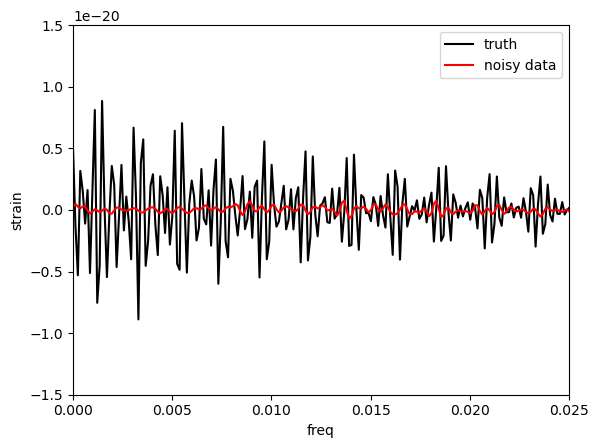

In [3]:
fig, ax = plt.subplots()

ax.plot(waveform_generator.time_array, waveform_generator.time_domain_strain(injection_parameters)['plus'], "k", label="truth")
ax.plot(waveform_generator.time_array, ifos[0].time_domain_strain, "r", label="noisy data")

ax.set_xlim(0, 0.025)
ax.set_ylim(-1.5e-20, 1.5e-20)
ax.set_xlabel("freq")
ax.set_ylabel("strain")
ax.legend()

In [ ]:
prior = injection_parameters.copy()

for j in [0, 1]:
    prior[f"w_{j}"] = bilby.core.prior.LogUniform(1e-20, 1e-19)
    prior[f"f_{j}"] = bilby.core.prior.Uniform(1000, 5000)
    prior[f"T_{j}"] = bilby.core.prior.LogUniform(1e-4, 0.1)
    prior[f"psi_{j}"] = bilby.core.prior.Uniform(-np.pi, np.pi)
    prior[f"alpha_{j}"] = bilby.core.prior.Uniform(-6, 0)

# pprint.pp(prior)

likelihood = bilby.gw.GravitationalWaveTransient(
    interferometers=ifos, waveform_generator=waveform_generator
)

result = bilby.core.sampler.run_sampler(
    likelihood,
    prior,
    sampler="dynesty",
    npoints=500,
    walks=5,
    nact=3,
    injection_parameters=injection_parameters,
    outdir=outdir,
    label=label,
    result_class=bilby.gw.result.CBCResult,
)

In [ ]:
result.plot_corner(save=False)
plt.show()
plt.close()

In [ ]:
pprint.pp(injection_parameters)

In [ ]:
fig, ax = plt.subplots()

ax.plot(ifos[0].time_array, waveform_generator.time_domain_strain(injection_parameters)['plus'], "k", label="truth")

for j,i in enumerate(np.random.choice(len(result.posterior), 50, replace=False)):
    sample = result.posterior.iloc[i]
    sample_parameters = {k: sample[k] for k in injection_parameters.keys()}
    y_pred = waveform_generator.time_domain_strain(sample_parameters)['plus']
    
    ax.plot(ifos[0].time_array, y_pred, color='C1', alpha=0.04, label="envelope" if j==0 else None)

ax.set_xlim(0, 0.025)
ax.set_ylim(-1.5e-20, 1.5e-20)
ax.set_xlabel("time")
ax.set_ylabel("strain")
ax.legend()

In [ ]:
fig, ax = plt.subplots()

# ax.plot(ifos[0].frequency_array, ifos[0].frequency_domain_strain, "r", label="noisy data")
sqrt_f = np.sqrt(ifos[0].frequency_array)

ax.plot(ifos[0].frequency_array, waveform_generator.frequency_domain_strain(injection_parameters)['plus'] * sqrt_f, "k", label="truth")

for j,i in enumerate(np.random.choice(len(result.posterior), 500, replace=False)):
    sample = result.posterior.iloc[i]
    sample_parameters = {k: sample[k] for k in injection_parameters.keys()}
    y_pred = waveform_generator.frequency_domain_strain(sample_parameters)['plus']
    
    ax.plot(ifos[0].frequency_array, y_pred * sqrt_f, color='C1', alpha=0.04, label="envelope" if j==0 else None)

ax.set_xlim(1000, 5000)
ax.set_ylim(1e-24, 1e-20)
ax.set_yscale('log')
ax.set_xlabel("frequency")
ax.set_ylabel("strain")
ax.legend()